A study of the bandwidth regularizers in
`src.experiments.harmonics.bw_loss`

## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataclasses
import logging
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
sys.path.append("..")

import src.experiments.harmonics.bw_loss as bw_loss
from src.experiments.harmonics.fc_net import FCNet, FCNetConfig
from src.experiments.harmonics.harmonics import (
    HarmonicDataModule,
    HarmonicFn,
    HarmonicFnTrainable,
    HarmonicFnConfig,
)

# Analysis time

### Function that is truly bandlimited

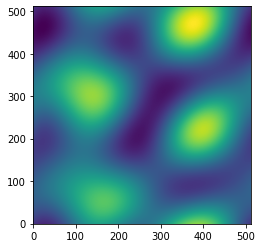

In [4]:
hf = HarmonicFn(
    cfg=HarmonicFnConfig(
        input_dim=4,
        freq_limit=2,
        num_components=16,
        seed=-1,
    )
)
hf.viz_2d(side_samples=512, pad=(1,1), value=0.9)

In [5]:
mc_ns = np.array(list(range(1, 1000, 2)))
with torch.no_grad():
    mc_losses = np.array([
        bw_loss.high_freq_norm_mcls(
            fn=hf.forward,
            input_dim=hf.cfg.input_dim,
            bandlimit=2,
            n_samples=n,
            device=hf.device,
        ) for n in tqdm(mc_ns)
    ])
    
dft_sss = np.array([1, 2, 3, 4, 5, 6, 7, 8])
with torch.no_grad():
    dft_losses = np.array([
        bw_loss.high_freq_norm_dft(
            fn=hf.forward,
            input_dim=hf.cfg.input_dim,
            bandlimit=2,
            side_samples=ss,
            device=hf.device,
        ) for ss in tqdm(dft_sss)
    ])
dft_ns = dft_sss ** hf.cfg.input_dim

100%|██████████| 8/8 [00:00<00:00, 436.72it/s]


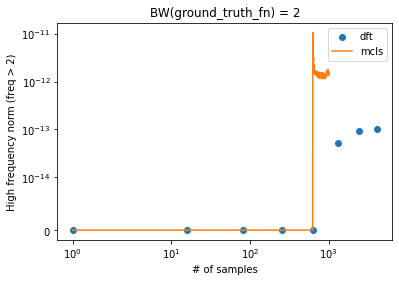

In [6]:
plt.scatter(dft_ns, dft_losses, label="dft")
plt.plot(mc_ns, mc_losses, label="mcls", color="tab:orange")

plt.yscale("symlog", linthresh=1e-14)
plt.xscale("symlog")

plt.ylabel("High frequency norm (freq > 2)")
plt.xlabel("# of samples")
plt.title("BW(ground_truth_fn) = 2")
plt.legend();

## Function (HF) that is not bandlimited

Parameter containing:
tensor([[ 1., -2.,  3., -1.],
        [-3.,  3.,  3., -2.],
        [ 2.,  3.,  1.,  2.],
        [ 1.,  0.,  2.,  3.],
        [-3., -3., -3., -3.]])
Parameter containing:
tensor([ 0.7246, -0.2334,  0.6077, -0.2218, -0.0449])
Parameter containing:
tensor([2.6226, 5.4167, 2.5809, 5.1398, 5.0061])


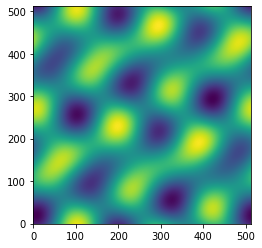

In [7]:
hf = HarmonicFn(
    cfg=HarmonicFnConfig(
        input_dim=4,
        freq_limit=3,
        num_components=5,
        seed=-1,
    )
)
hf.viz_2d(side_samples=512, pad=(1,1), value=5)
print(hf.freqs)
print(hf.coeffs)
print(hf.phases)

In [8]:
mc_ns = np.array(
    list(range(1, 500, 10))
    + list(range(500, 5000, 50))
    + [5000 * (2 ** x) for x in range(8)]
)
with torch.no_grad():
    mc_losses = np.array([
        bw_loss.high_freq_norm_mcls(
            fn=hf.forward,
            input_dim=hf.cfg.input_dim,
            bandlimit=2,
            n_samples=n,
            device=hf.device,
        ) for n in tqdm(mc_ns)
    ])
    
dft_sss = np.array(list(range(1, 20)))
with torch.no_grad():
    dft_losses = np.array([
        bw_loss.high_freq_norm_dft(
            fn=hf.forward,
            input_dim=hf.cfg.input_dim,
            bandlimit=2,
            side_samples=ss,
            device=hf.device,
        ) for ss in tqdm(dft_sss)
    ])
dft_ns = dft_sss ** hf.cfg.input_dim

100%|██████████| 19/19 [00:00<00:00, 278.45it/s]


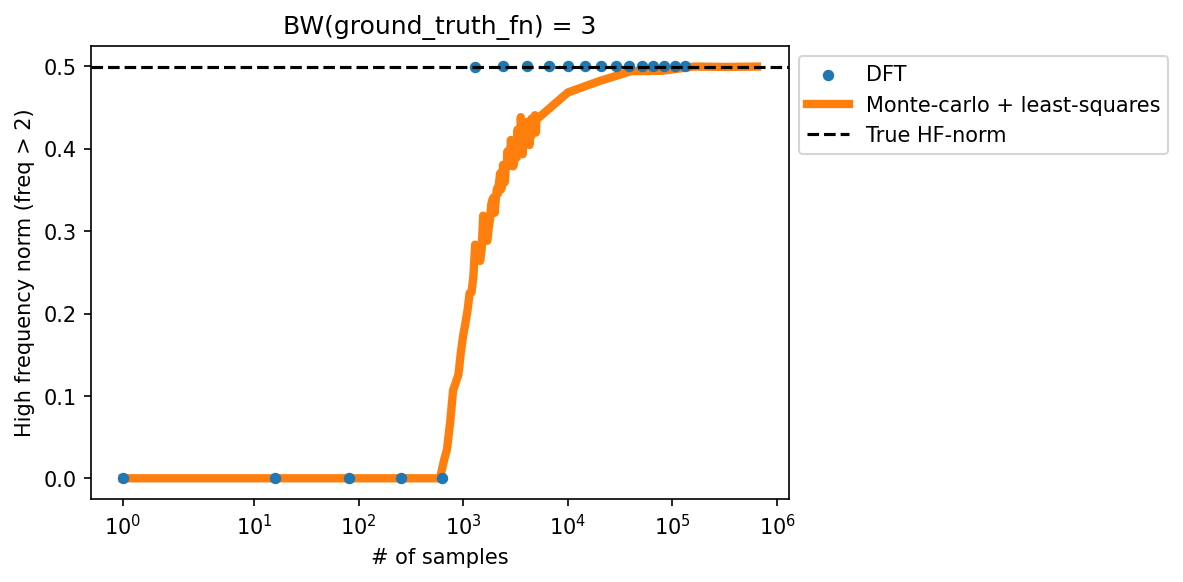

In [9]:
plt.figure(dpi=150)

plt.scatter(dft_ns, dft_losses, label="DFT", zorder=10, color="tab:blue", s=20)
plt.plot(mc_ns, mc_losses, label="Monte-carlo + least-squares", alpha=1, linewidth=4, color="tab:orange")

#plt.yscale("symlog", linthresh=1e-5)
plt.xscale("symlog")


plt.axhline(
    hf.coeffs[hf.freqs.max(axis=-1).values > 2].norm() ** 2 / 2,
    color="black", linestyle="--", zorder=10,
    label="True HF-norm"
)

plt.ylabel("High frequency norm (freq > 2)")
plt.xlabel("# of samples")
plt.title("BW(ground_truth_fn) = 3")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));

## Function (manual) that is not bandlimited

In [10]:
DIM = 2

def fn(xs: torch.Tensor) -> torch.Tensor:
    #return xs.sum(axis=-1)
    #return (xs * xs).sum(axis=-1)
    return torch.abs(xs.sum(axis=-1) - 1)

mc_ns = np.array(
    list(range(1, 500, 10))
    + list(range(500, 5000, 50))
    + [5000 * (2 ** x) for x in range(10)]
)
with torch.no_grad():
    mc_losses = np.array([
        bw_loss.high_freq_norm_mcls(
            fn=fn,
            input_dim=DIM,
            bandlimit=1,
            n_samples=n,
            device=hf.device,
        ) for n in tqdm(mc_ns)
    ])
    
dft_sss = np.array(list(range(1, 100)))
with torch.no_grad():
    dft_losses = np.array([
        bw_loss.high_freq_norm_dft(
            fn=fn,
            input_dim=DIM,
            bandlimit=1,
            side_samples=ss,
            device=hf.device,
        ) for ss in tqdm(dft_sss)
    ])
dft_ns = dft_sss ** DIM

100%|██████████| 99/99 [00:00<00:00, 1030.15it/s]


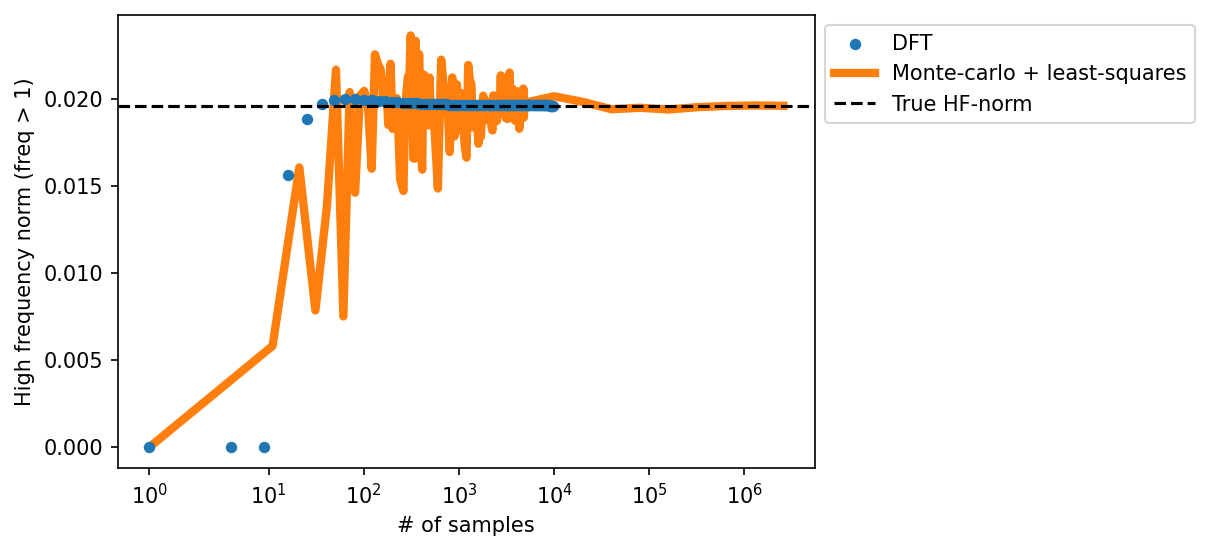

In [11]:
plt.figure(dpi=150)

plt.scatter(dft_ns, dft_losses, label="DFT", zorder=10, color="tab:blue", s=20)
plt.plot(mc_ns, mc_losses, label="Monte-carlo + least-squares", alpha=1, linewidth=4, color="tab:orange")

#plt.yscale("symlog", linthresh=1e-5)
plt.xscale("symlog")

plt.axhline(
    (np.pi ** 4 - 63) / (18 * np.pi ** 4),
    color="black", linestyle="--", zorder=10,
    label="True HF-norm"
)

plt.ylabel("High frequency norm (freq > 1)")
plt.xlabel("# of samples")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));

## Function (NN) that is not bandlimited

In [12]:
hf = HarmonicFn(
    cfg=HarmonicFnConfig(
        input_dim=4,
        freq_limit=2,
        num_components=16,
        seed=-1,
    )
)

dm = HarmonicDataModule(
    hf=hf,
    n_train=512,
    n_val=1000,
    train_seed=-1,
    val_seed=-1,
    num_workers=0,
    batch_size=256,
)

class CustomCallback(pl.Callback):
    def __init__(self, print_every: int):
        self.print_every = print_every
        self.epoch_idx = 0

    def on_train_epoch_end(self, trainer: pl.Trainer, *_, **__):
        float_metrics = {
            k: float(v) for k, v in trainer.logged_metrics.items()
        }
        if self.epoch_idx % self.print_every == 0:
            print(
                f"epoch: {self.epoch_idx:04}; "
                f"train_mse: {float_metrics['train_mse']:.6f}; "
              + f"val_mse: {float_metrics['val_mse']:.6f}"
            )
        self.epoch_idx += 1

trainer = pl.Trainer(
    gpus=1,
    deterministic=True,
    enable_checkpointing=False,
    logger=False,  # We do custom logging instead.
    log_every_n_steps=1,
    max_epochs=1000,
    callbacks=[
        EarlyStopping(
            monitor="val_mse",
            patience=100,
            mode="min",
        ),
        CustomCallback(print_every=100)
    ],
    enable_progress_bar=False,
    weights_summary=None,
)

pl.seed_everything(17)
net = FCNet(
    FCNetConfig(
        input_dim=hf.cfg.input_dim,
        layer_widths=(128, 128, 128, 1),
        learning_rate=3e-3,
        high_freq_lambda=0,
        high_freq_bandlimit=0,
        high_freq_mcls_samples=1,
    )
)
trainer.fit(
    model=net,
    datamodule=dm,
)

epoch: 0000; train_mse: 0.520611; val_mse: 0.472287
epoch: 0100; train_mse: 0.357569; val_mse: 0.420166
epoch: 0200; train_mse: 0.163719; val_mse: 0.375452
Epoch   279: reducing learning rate of group 0 to 3.0000e-04.
epoch: 0300; train_mse: 0.107741; val_mse: 0.350126
Epoch   305: reducing learning rate of group 0 to 3.0000e-05.
Epoch   331: reducing learning rate of group 0 to 3.0000e-06.


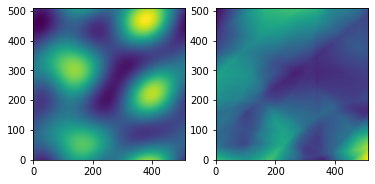

In [13]:
plt.subplot(1, 2, 1)
hf.viz_2d(side_samples=512, pad=(1,1), value=0.9)
plt.subplot(1, 2, 2)
net.viz_2d(side_samples=512, pad=(1,1), value=0.9)

In [14]:
mc_ns = np.array(
    list(range(1, 500, 10))
    + list(range(500, 5000, 50))
    + [5000 * (2 ** x) for x in range(10)]
)
with torch.no_grad():
    mc_losses = np.array([
        bw_loss.high_freq_norm_mcls(
            fn=net.forward,
            input_dim=hf.cfg.input_dim,
            bandlimit=2,
            n_samples=n,
            device=hf.device,
        ) for n in tqdm(mc_ns)
    ])

100%|██████████| 150/150 [01:06<00:00,  2.25it/s]


In [15]:
dft_sss = np.array(list(range(1, 75)))
with torch.no_grad():
    dft_losses = np.array([
        bw_loss.high_freq_norm_dft(
            fn=net.forward,
            input_dim=hf.cfg.input_dim,
            bandlimit=2,
            side_samples=ss,
            device=hf.device,
        ) for ss in tqdm(dft_sss)
    ])
dft_ns = dft_sss ** hf.cfg.input_dim

100%|██████████| 74/74 [01:07<00:00,  1.09it/s] 


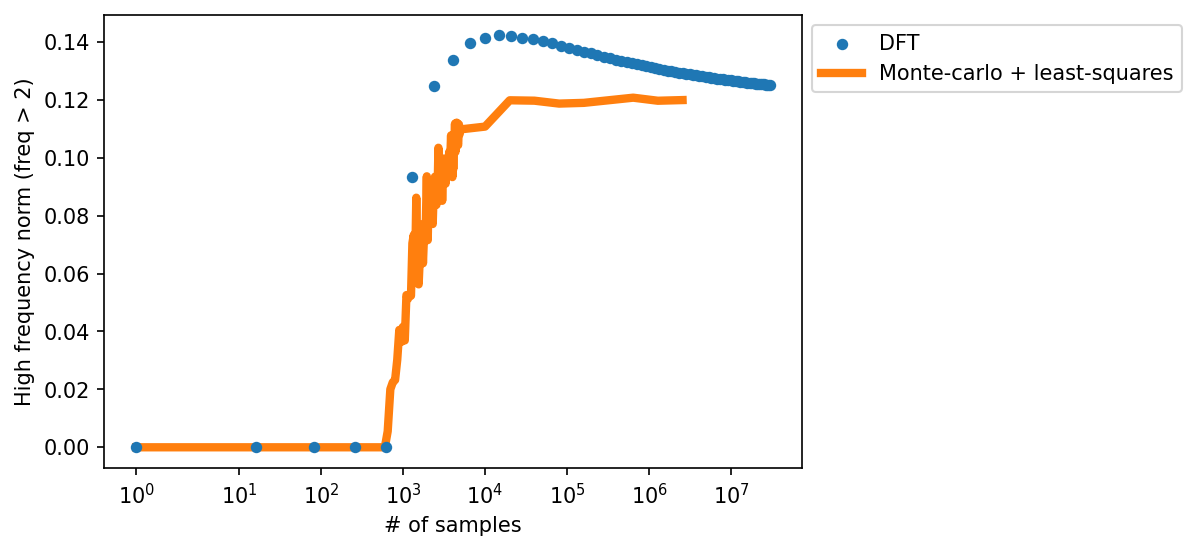

In [16]:
plt.figure(dpi=150)

plt.scatter(dft_ns, dft_losses, label="DFT", zorder=10, color="tab:blue", s=20)
plt.plot(mc_ns, mc_losses, label="Monte-carlo + least-squares", alpha=1, linewidth=4, color="tab:orange")

#plt.yscale("symlog", linthresh=1e-5)
plt.xscale("symlog")

plt.ylabel("High frequency norm (freq > 2)")
plt.xlabel("# of samples")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));